<a href="https://colab.research.google.com/github/EnsiyehRaoufi/Claims-Knowledge-Graph/blob/main/ClaimsKG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Claims Knowledge Graph Classification

### Introduction

"ClaimsKG is a structured database which serves as a registry of claims. It provides an entry point for researchers to discover claims and involved entities, also providing links to fact-checking sites and their results. Basis of the database is a knowledge graph which provides data about claims, metadata (such as their publishing site), involved entities (which we have annotated using state-of-the-art NLP techniques) and some normalized truth ratings. ClaimsKG is generated through a (semi-)automated pipeline which harvests claims and respective metadata from popular fact-checking sites on a regular basis, lifts data into an RDF/S model, which exploits established schema such as schema.org and NIF, and annotates claims with related entities from DBpedia." [[1]](#1)

I extracted the true, false and mixture claims using ClaimsKG's web interface [Claim Explorer](https://data.gesis.org/claimskg/explorer/home). There are 27588 goal claims (4404 True, 12350 False, 10834 Mixture).

Because this explorer export the results to a csv form just for a maximum of 10000 rows, so I exported each of true, false and mixture records in separate csv files. Because the distribution of all types of claims is not uniform, and both of the false and mixture claims have more than 10000 records, we lost 3184 claims to extract. But in comparison with the data set size and also, regarding to a low difference between number of total false and mixture claims, I guess it's not going to make a mistake. 

### Example
### Cleaning
### Final Advice

-------------------
<a id="1">[1]</a> 
https://data.gesis.org/claimskg/site/

# Data Set

The data is contained in three files:

* claimskg_false.csv - containing false claims and meta data about each claim (text, date, author,keywords, source, etc.)
* claimskg_mixture.csv - containing mixture claims and meta data about each claim (text, date, author,keywords, source, etc.)
* claimskg_true.csv - containing true claims and meta data about each claim (text, date, author,keywords, source, etc.)

Each of these 3 csv files contains below features:

* id (object) - claim link
* text (object) - claim text
* date (object) - claim published date
* truthRating (int64) - 
* ratingName (bool)
* author (object)
* headline (object)
* named_entities_claim (object)
* named_entities_article (object)
* keywords (object)
* source (object)
* sourceURL (object)
* link (object)
* language (object)

**Note:** You may need to 

# Installing and importing required packages

In [1]:
!pip install numpy --upgrade
!pip install autogluon --no-cache-dir

     |████████████████████████████████| 15.7 MB 5.3 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 56 kB 5.3 MB/s 
     |████████████████████████████████| 52 kB 25.3 MB/s 
     |████████████████████████████████| 273 kB 57.5 MB/s 
     |████████████████████████████████| 352 kB 15.6 MB/s 
     |████████████████████████████████| 27.4 MB 14.7 MB/s 
     |████████████████████████████████| 132 kB 64.9 MB/s 
     |████████████████████████████████| 22.3 MB 1.2 MB/s 
     |████████████████████████████████| 210 kB 60.1 MB/s 
     |████████████████████████████████| 4.2 MB 50.0 MB/s 
     |████████████████████████████████| 837 kB 79.7 MB/s 
     |████████████████████████████████| 119 kB 67.9 MB/s 
     |████████████████████████████████| 1.3 MB 59.8 MB/s 
     |████████████████████████████████| 3.0 MB 51.4 MB/s 
     |████████████████████████████████| 296 kB 77.2 MB/s 
     |████████████████████████████████| 2.0 MB 45.5 MB/s 
     |████████████████████████████████| 67.3 MB 1.1 MB/s 
     |████████████████████████████████| 189 kB 52.0 MB/s 
     |██████████

In [13]:
import datetime
import time
import tarfile
import math
import json
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#import boto3
#from sagemaker import get_execution_role
#import sagemaker

#sm_boto3 = boto3.client("sagemaker")
#sess = sagemaker.Session()
#region = sess.boto_session.region_name
#bucket = sess.default_bucket()  # this could also be a hard-coded bucket name
#print("Using bucket " + bucket)

In [14]:
#To connect to google drive in colab
from google.colab import drive
drive.mount('/content/MyDrive')
%cd MyDrive/MyDrive/claimskg
%pwd

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).
[Errno 2] No such file or directory: 'MyDrive/MyDrive/claimskg'
/content/MyDrive/MyDrive/claimskg


'/content/MyDrive/My Drive/claimskg'

# Reading and cleansing data

In [62]:
# read in the csv file
claims_true = pd.read_csv('claimskg_true.csv', parse_dates=['date'])
claims_false = pd.read_csv('claimskg_false.csv', parse_dates=['date'])
claims_mixture = pd.read_csv('claimskg_mixture.csv', parse_dates=['date'])

In [63]:
# Concatenating 3 tables
claimskg = pd.concat([claims_true, claims_false, claims_mixture], ignore_index=True,)

# Watch the raw input table
claimskg

,id,text,date,truthRating,ratingName,author,headline,named_entities_claim,named_entities_article,keywords,source,sourceURL,link,language
0,http://data.gesis.org/claimskg/claim_review/36...,'There will be no public funding for abortion ...,2010-03-21,3,True,Bart Stupak,Stupak revises abortion stance on health care ...,"Abortion rights,Barack Obama,Bart Stupak,Ben N...",abortion,"Abortion,Health Care",politifact,http://www.politifact.com,http://www.politifact.com/truth-o-meter/statem...,English
1,http://data.gesis.org/claimskg/claim_review/e6...,Central Health 'is the only hospital district ...,2011-03-15,3,True,Wayne Christian,State Rep. Wayne Christian says Central Health...,"Austin American-Statesman,Harris County Hospit...",NaN,Abortion,politifact,http://www.politifact.com,http://www.politifact.com/texas/statements/201...,English
2,http://data.gesis.org/claimskg/claim_review/e0...,Says most of Perry's chiefs of staff have been...,2010-08-14,3,True,Bill White,Bill White says most of Gov. Rick Perry's chie...,"AT&T,Bill Clements,Bill White,Bracewell & Giul...",NaN,Ethics,politifact,http://www.politifact.com,http://www.politifact.com/texas/statements/201...,English
3,http://data.gesis.org/claimskg/claim_review/48...,Says 'as Co-Chair of the Joint Ways & Means Co...,2012-09-28,3,True,Mary Nolan,Did Mary Nolan secure funding for Milwaukie br...,"Carolyn Tomei,Dave Hunt,Fetsch,Jeff Merkley,Ka...",Portland-Milwaukie Light Rail project,"State Budget,State Finances,Transportation",politifact,http://www.politifact.com,http://www.politifact.com/oregon/statements/20...,English
4,http://data.gesis.org/claimskg/claim_review/80...,Says Gary Farmer’s claim that he 'received an ...,2016-07-08,3,True,Jim Waldman,Florida Senate candidate never actually receiv...,"Gary Farmer,Gwyndolen Clarke-Reed,Jim Waldman,...",Gary Farmer,Guns,politifact,http://www.politifact.com,http://www.politifact.com/florida/statements/2...,English
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24447,http://data.gesis.org/claimskg/claim_review/41...,'The city that I was mayor of was 50 percent L...,2018-06-07,2,MIXTURE,Lou Barletta,Hazleton wasn’t half-Latino when Lou Barletta ...,"Barletta,Bob Casey,Fox Business Network,Hazlet...",Latino,Immigration,politifact,http://www.politifact.com,http://www.politifact.com/pennsylvania/stateme...,English
24448,http://data.gesis.org/claimskg/claim_review/9e...,A set of images show a congenital anomaly that...,Unknown,2,MIXTURE,Unknown,Is This a Real Hand With Eight Fingers?,"American Society for Surgery of the Hand,Bilas...",NaN,"hands, Medical, medical anomalies, mirror hand",snopes,http://www.snopes.com,https://www.snopes.com/fact-check/real-hand-ei...,English
24449,http://data.gesis.org/claimskg/claim_review/1a...,'You see 34 people (are) murdered every single...,2012-12-23,2,MIXTURE,Cory Booker,Cory Booker says 34 Americans are killed by gu...,"ABC,Centers for Disease Control and Prevention...",NaN,"Crime,Guns",politifact,http://www.politifact.com,http://www.politifact.com/new-jersey/statement...,English
24450,http://data.gesis.org/claimskg/claim_review/28...,'White men have committed more mass shootings ...,2017-10-02,2,MIXTURE,Newsweek,Are white males responsible for more mass shoo...,"2015 San Bernardino shooting,Aurora, Colo,Foll...",NaN,Guns,politifact,http://www.politifact.com,http://www.politifact.com/punditfact/statement...,English


In [64]:
#View true claims infographic
claimskg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24452 entries, 0 to 24451
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      24452 non-null  object
 1   text                    24452 non-null  object
 2   date                    24452 non-null  object
 3   truthRating             24452 non-null  int64 
 4   ratingName              24452 non-null  object
 5   author                  24452 non-null  object
 6   headline                24452 non-null  object
 7   named_entities_claim    24421 non-null  object
 8   named_entities_article  15340 non-null  object
 9   keywords                23162 non-null  object
 10  source                  24452 non-null  object
 11  sourceURL               24452 non-null  object
 12  link                    24452 non-null  object
 13  language                24452 non-null  object
dtypes: int64(1), object(13)
memory usage: 2.6+ MB


In [65]:
source_list = claimskg.source.unique()
source_list

array(['politifact', 'snopes', 'africacheck', 'truthorfiction',
       'factscan', 'checkyourfact'], dtype=object)

In [66]:

#One-hot encoding of the events column and deleting the event itself
for chan in source_list:
    claims_true[chan] = claimskg.source.apply(lambda x: 1 if x==chan else 0)
claims_true.pop('source')
claims_true

,id,text,date,truthRating,ratingName,author,headline,named_entities_claim,named_entities_article,keywords,sourceURL,link,language,politifact,snopes,africacheck,truthorfiction,factscan,checkyourfact
0,http://data.gesis.org/claimskg/claim_review/36...,'There will be no public funding for abortion ...,2010-03-21,3,True,Bart Stupak,Stupak revises abortion stance on health care ...,"Abortion rights,Barack Obama,Bart Stupak,Ben N...",abortion,"Abortion,Health Care",http://www.politifact.com,http://www.politifact.com/truth-o-meter/statem...,English,1,0,0,0,0,0
1,http://data.gesis.org/claimskg/claim_review/e6...,Central Health 'is the only hospital district ...,2011-03-15,3,True,Wayne Christian,State Rep. Wayne Christian says Central Health...,"Austin American-Statesman,Harris County Hospit...",NaN,Abortion,http://www.politifact.com,http://www.politifact.com/texas/statements/201...,English,1,0,0,0,0,0
2,http://data.gesis.org/claimskg/claim_review/e0...,Says most of Perry's chiefs of staff have been...,2010-08-14,3,True,Bill White,Bill White says most of Gov. Rick Perry's chie...,"AT&T,Bill Clements,Bill White,Bracewell & Giul...",NaN,Ethics,http://www.politifact.com,http://www.politifact.com/texas/statements/201...,English,1,0,0,0,0,0
3,http://data.gesis.org/claimskg/claim_review/48...,Says 'as Co-Chair of the Joint Ways & Means Co...,2012-09-28,3,True,Mary Nolan,Did Mary Nolan secure funding for Milwaukie br...,"Carolyn Tomei,Dave Hunt,Fetsch,Jeff Merkley,Ka...",Portland-Milwaukie Light Rail project,"State Budget,State Finances,Transportation",http://www.politifact.com,http://www.politifact.com/oregon/statements/20...,English,1,0,0,0,0,0
4,http://data.gesis.org/claimskg/claim_review/80...,Says Gary Farmer’s claim that he 'received an ...,2016-07-08,3,True,Jim Waldman,Florida Senate candidate never actually receiv...,"Gary Farmer,Gwyndolen Clarke-Reed,Jim Waldman,...",Gary Farmer,Guns,http://www.politifact.com,http://www.politifact.com/florida/statements/2...,English,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4447,http://data.gesis.org/claimskg/claim_review/d7...,A pedestrian was killed by a flying fire hydrant.,Unknown,3,True,Unknown,Fire Hydrant Death,"Associated Press,Encinitas, California,Fire Hy...",fire hydrant,"ASP Article, freakish fatalities",http://www.snopes.com,https://www.snopes.com/fact-check/fire-plugged/,English,0,1,0,0,0,0
4448,http://data.gesis.org/claimskg/claim_review/b5...,'The United States is the ONLY industrialized ...,2019-04-30,3,True,Mark Pocan,Universal health care diagnosis is on the mark,"Affordable Care Act,Australia,Austria,Belarus,...",NaN,"Health Care,Medicaid,Medicare",http://www.politifact.com,http://www.politifact.com/wisconsin/statements...,English,1,0,0,0,0,0
4449,http://data.gesis.org/claimskg/claim_review/05...,A 17-year-old Nigerian girl was publicly flogg...,Unknown,3,True,Unknown,Bariya Ibrahim Magazu Petition,"Abuja,Associated Press,Barbara “faith,Dallas M...",premarital sex,"ASP Article, Petitions",http://www.snopes.com,https://www.snopes.com/fact-check/the-cane-mut...,English,0,1,0,0,0,0
4450,http://data.gesis.org/claimskg/claim_review/7d...,'We haven’t had control of the House for the l...,2010-10-18,3,True,William G. Batchelder,Republican state Rep. Bill Batchelder knocks D...,"Armond Budish,Democrat,PolitiFact,Republican",NaN,Government Efficiency,http://www.politifact.com,http://www.politifact.com/ohio/statements/2010...,English,1,0,0,0,0,0


In [69]:
#Because languages of all claims are English, so we can neglect the column 'language'
print("Languges of the true, false and mixture claims: ", claimskg.language.unique())

Languges of the true, false and mixture claims:  ['English']


In [ ]:
#transcript_value contains each of keys of value column in a separate column 
claims_true = pd.json_normalize(claims_true['source'])

#Merging 'offer id' and 'offer_id' columns to 'offers' column, because by type of event we can see that an offer received, viewed or completed 
transcript_value['offers'] = transcript_value['offer id'].fillna(transcript_value['offer_id'])

#Deleting 'offer id' and 'offer_id' columns
transcript_value = transcript_value.drop(['offer_id', 'offer id'], axis = 1)

#deleting the value column from transcript 
transcript = transcript.drop(['value'], axis = 1)

#concatenating the separated columns of value in the transcript_value to the transcript
transcript = pd.concat([transcript, transcript_value], axis=1)

#observing categorical data in event and offers columns
print("event types:", np.unique(transcript['event']))
print("offers ids:", transcript['offers'].unique())

#One-hot encoding of the events column and deleting the event itself
for chan in ['offer_completed', 'offer_received', 'offer_viewed', 'transaction']:
    transcript[chan] = transcript.event.apply(lambda x: 1 if x==chan.replace('_',' ') else 0)
transcript.pop('event')

#Filling the NaN in transcript table
transcript['amount'] = transcript['amount'].fillna(0)
transcript['reward'] = transcript['reward'].fillna(0)

event types: ['offer completed' 'offer received' 'offer viewed' 'transaction']
offers ids: ['9b98b8c7a33c4b65b9aebfe6a799e6d9' '0b1e1539f2cc45b7b9fa7c272da2e1d7'
 '2906b810c7d4411798c6938adc9daaa5' 'fafdcd668e3743c1bb461111dcafc2a4'
 '4d5c57ea9a6940dd891ad53e9dbe8da0' 'f19421c1d4aa40978ebb69ca19b0e20d'
 '2298d6c36e964ae4a3e7e9706d1fb8c2' '3f207df678b143eea3cee63160fa8bed'
 'ae264e3637204a6fb9bb56bc8210ddfd' '5a8bc65990b245e5a138643cd4eb9837' nan]


In [ ]:
#Watching the infographic of its whole data
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   person           306534 non-null  object 
 1   time             306534 non-null  int64  
 2   amount           306534 non-null  float64
 3   reward           306534 non-null  float64
 4   offers           167581 non-null  object 
 5   offer_completed  306534 non-null  int64  
 6   offer_received   306534 non-null  int64  
 7   offer_viewed     306534 non-null  int64  
 8   transaction      306534 non-null  int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 21.0+ MB


In [ ]:
#View the edited transcript table
transcript

,person,time,amount,reward,offers,offer_completed,offer_received,offer_viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,0.00,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,0.00,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,0.00,0.0,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0.00,0.0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,0.00,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,714,1.59,0.0,NaN,0,0,0,1
306530,68213b08d99a4ae1b0dcb72aebd9aa35,714,9.53,0.0,NaN,0,0,0,1
306531,a00058cf10334a308c68e7631c529907,714,3.61,0.0,NaN,0,0,0,1
306532,76ddbd6576844afe811f1a3c0fbb5bec,714,3.53,0.0,NaN,0,0,0,1


In [ ]:
#Saving transcript as a csv file
transcript.to_csv("transcript_edited.csv",index=False)

## portfolio table

In [ ]:
#View the raw table of portfolio
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [ ]:
#One-hot encoding of the channels column and deleting the channels column itself
for chan in ['web', 'email', 'mobile', 'social']:
    portfolio[chan] = portfolio.channels.apply(lambda x: 1 if chan in x else 0)
portfolio.pop('channels')

#One-hot encoding of the offer_type column and deleting the offer_type column itself
for chan in ['bogo', 'discount', 'informational']:
    portfolio[chan] = portfolio.offer_type.apply(lambda x: 1 if x==chan else 0)
portfolio.pop('offer_type')

#Renaming columns to avoid in common names with the profile table
portfolio = portfolio.rename(columns={'reward': 'offer_reward', 'duration': 'offer_duration',
                                      'difficulty': 'offer_difficulty'})


In [ ]:
#View the infographic of the portfolio table
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   offer_reward      10 non-null     int64 
 1   offer_difficulty  10 non-null     int64 
 2   offer_duration    10 non-null     int64 
 3   id                10 non-null     object
 4   web               10 non-null     int64 
 5   email             10 non-null     int64 
 6   mobile            10 non-null     int64 
 7   social            10 non-null     int64 
 8   bogo              10 non-null     int64 
 9   discount          10 non-null     int64 
 10  informational     10 non-null     int64 
dtypes: int64(10), object(1)
memory usage: 1008.0+ bytes


In [ ]:
#View edited portfolio table
portfolio

,offer_reward,offer_difficulty,offer_duration,id,web,email,mobile,social,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,0,1,0


In [ ]:
#Saving portfolio as a csv file
portfolio.to_csv("portfolio_edited.csv",index=False)

## profile table

In [ ]:
profile = pd.read_json('profile.json', orient='records', lines=True, )

In [ ]:
#View the raw table of profile
profile

In [ ]:
#Reading the became_member_on column as date type and parse it to year and months
profile.to_csv('profile_edited.csv', index=False)
profile = pd.read_csv('profile_edited.csv', parse_dates=['became_member_on'])
profile['year'] = profile['became_member_on'].dt.year
profile['month'] = profile['became_member_on'].dt.month
profile

,gender,age,id,became_member_on,income,year,month
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017,2
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7
2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018,7
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5
4,NaN,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017,8
...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,2018,6
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,2018,7
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,2017,1
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,2016,3


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'income'}>],
       [<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'month'}>]], dtype=object)

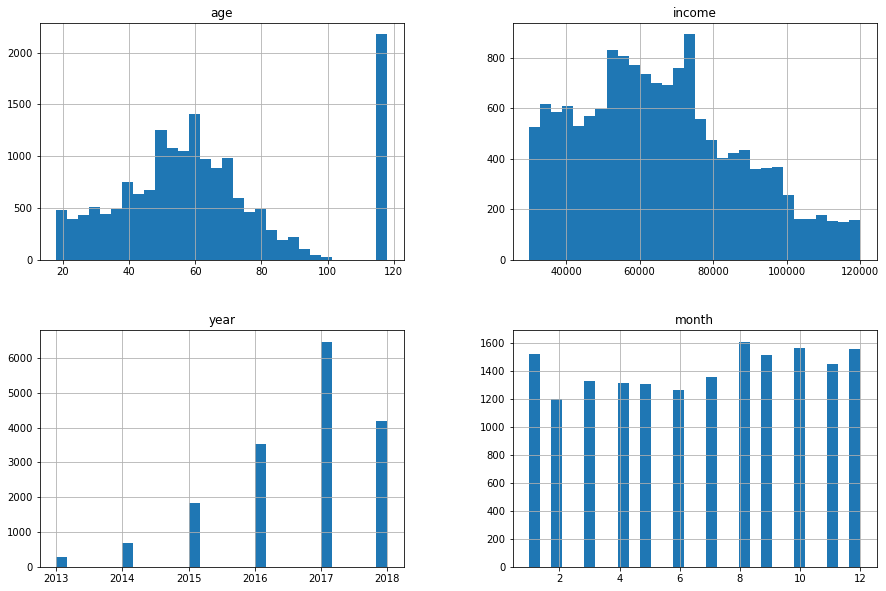

In [ ]:
#View the raw data plots before filling the NaNs 
profile.hist(bins=30, figsize=(15,10))

In [ ]:
#Creating one column named 'membership_duration' instead of the 'became_member_on', 'year', 'month' columns
this_year = datetime.datetime.today().year
this_month = datetime.datetime.today().month
#print(f"This year: {this_year}, This month: {this_month}")

#creating the column 'membership_duration' that contains membership duration in month
profile['membership_duration'] = (this_year-profile['year'])*12 + (12-profile['month']+this_month)
for col in ['became_member_on', 'year', 'month']:
    profile.pop(col)

In [ ]:
#investigate the number of the NaN cells to fill
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               14825 non-null  object 
 1   age                  17000 non-null  int64  
 2   id                   17000 non-null  object 
 3   income               14825 non-null  float64
 4   membership_duration  17000 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [ ]:
#Calculating the average of people whose ages are not 118
mean_age = profile['age'][profile['age']!=118].mean()
mean_age = int(mean_age)

#fill the NaN cells of the age column with average age
profile.loc[profile.age == 118, 'age'] = mean_age

#fill the NaN cells of the income column with the average income
mean_income = round(np.mean(profile['income']),0)
profile['income'] = profile['income'].fillna(mean_income)

O_count = profile[profile['gender']=='O']['gender'].count()
print(f"There are {O_count} persons having non obvious gender")

#fill the NaN cells of gender column in random, we don't Other genders for random choicing because of their minority

num_na = profile['gender'].isna().sum()  # number of missing cases
profile.loc[profile['gender'].isna(), 'gender'] = random.choices(["M", "F"], k=num_na)

There are 212 persons having non obvious gender


In [ ]:
#One-hot encoding of the gender column
print("gender types: ", profile.gender.unique())

for chan in ['M', 'F', 'O']:
    profile[chan] = profile.gender.apply(lambda x: 1 if x==chan else 0)
profile.pop('gender')

#Renaming to appropriate names
profile = profile.rename(columns={'F': 'Female', 'M': 'Male', 'O': 'Other'})

gender types:  ['F' 'M' 'O']


In [ ]:
#View edited profile table
profile

,age,id,income,membership_duration,Male,Female,Other
0,54,68be06ca386d4c31939f3a4f0e3dd783,65405.0,72,0,1,0
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,67,0,1,0
2,54,38fe809add3b4fcf9315a9694bb96ff5,65405.0,55,0,1,0
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,69,0,1,0
4,54,a03223e636434f42ac4c3df47e8bac43,65405.0,66,0,1,0
...,...,...,...,...,...,...,...
16995,45,6d5f3a774f3d4714ab0c092238f3a1d7,54000.0,56,0,1,0
16996,61,2cb4f97358b841b9a9773a7aa05a9d77,72000.0,55,1,0,0
16997,49,01d26f638c274aa0b965d24cefe3183f,73000.0,73,1,0,0
16998,83,9dc1421481194dcd9400aec7c9ae6366,50000.0,83,0,1,0


In [ ]:
#Check to see if we have NaN cells
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  17000 non-null  int64  
 1   id                   17000 non-null  object 
 2   income               17000 non-null  float64
 3   membership_duration  17000 non-null  int64  
 4   Male                 17000 non-null  int64  
 5   Female               17000 non-null  int64  
 6   Other                17000 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 929.8+ KB


In [ ]:
#Saving the profile table as a csv file
profile.to_csv("profile_edited.csv", index=False)

# Merging all Data

In [ ]:
transcript = pd.read_csv("transcript_edited.csv")
portfolio = pd.read_csv("portfolio_edited.csv")
profile = pd.read_csv("profile_edited.csv")

In [ ]:
#Merging transcript and profile tables on the joint person ids
transcript_profile_merged = pd.merge(transcript, profile, left_on='person', 
                                     right_on='id', how='left').drop('id', axis=1)

In [ ]:
#Merge the above table with the portfolio table on the joint offer ids
my_starbuck = pd.merge(transcript_profile_merged, portfolio, left_on='offers',
                       right_on='id', how='left').drop('id', axis=1)

In [ ]:
#Adding total transaction amount as a column to the above dataframe
total_transcript = ((my_starbuck['amount']).groupby(my_starbuck['person'])).sum()
total_transcript_df = pd.DataFrame({'id':total_transcript.index, 'total_transaction':total_transcript.values})
my_starbuck = pd.merge(my_starbuck, total_transcript_df, left_on='person',
                       right_on='id', how='left').drop('id', axis=1)

#Converting time from hours to days, because offer's times are in days
my_starbuck['time'] /= 24.0
my_starbuck['time'] = np.ceil(my_starbuck['time'])

#Sorting the dataframe based on person ids and time
my_starbuck = my_starbuck.sort_values(['person','time',])

#changing non zero entries of the reward column to 1, to remove dependendy of it with column offer_reward
my_starbuck['reward'] = my_starbuck.reward.apply(lambda x: 1 if x!=0 else 0)
my_starbuck

#Adding cumulative amount of transactions as the 'cumsum' column to my dataframe
my_starbuck['cumsum'] = (my_starbuck['amount']).groupby(my_starbuck['person']).cumsum()

my_starbuck

,person,time,amount,reward,offers,offer_completed,offer_received,offer_viewed,transaction,age,...,offer_duration,web,email,mobile,social,bogo,discount,informational,total_transaction,cumsum
55972,0009655768c64bdeb2e877511632db8f,7.0,0.00,0,5a8bc65990b245e5a138643cd4eb9837,0,1,0,0,33,...,3.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,127.60,0.00
77705,0009655768c64bdeb2e877511632db8f,8.0,0.00,0,5a8bc65990b245e5a138643cd4eb9837,0,0,1,0,33,...,3.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,127.60,0.00
89291,0009655768c64bdeb2e877511632db8f,10.0,22.16,0,NaN,0,0,0,1,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.60,22.16
113605,0009655768c64bdeb2e877511632db8f,14.0,0.00,0,3f207df678b143eea3cee63160fa8bed,0,1,0,0,33,...,4.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,127.60,22.16
139992,0009655768c64bdeb2e877511632db8f,16.0,0.00,0,3f207df678b143eea3cee63160fa8bed,0,0,1,0,33,...,4.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,127.60,22.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258361,ffff82501cea40309d5fdd7edcca4a07,24.0,14.23,0,NaN,0,0,0,1,45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,226.07,197.04
258362,ffff82501cea40309d5fdd7edcca4a07,24.0,0.00,1,2906b810c7d4411798c6938adc9daaa5,1,0,0,0,45,...,7.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,226.07,197.04
262475,ffff82501cea40309d5fdd7edcca4a07,25.0,0.00,0,2906b810c7d4411798c6938adc9daaa5,0,0,1,0,45,...,7.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,226.07,197.04
274809,ffff82501cea40309d5fdd7edcca4a07,26.0,10.12,0,NaN,0,0,0,1,45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,226.07,207.16


In [ ]:
#Assigning the cumsum column to the amount column and deleting cumsum
my_starbuck['amount'] = my_starbuck['cumsum']
my_starbuck.pop('cumsum')

#Renaming amount column
my_starbuck = my_starbuck.rename(columns={'amount':'cumulative_transaction'})

#Decreasing the table size and just selecting rows that contain an offer (received/viewed/completed)
my_starbuck = my_starbuck[my_starbuck['transaction']==0].copy()

#Deleting the transaction column
my_starbuck.pop('transaction')

my_starbuck['offers'] = my_starbuck['offers'].astype('category')

#Reseting my goal table indexes
my_starbuck.reset_index(drop=True, inplace=True)

In [ ]:
#View the edited table to work with
my_starbuck

,person,time,cumulative_transaction,reward,offers,offer_completed,offer_received,offer_viewed,age,income,...,offer_difficulty,offer_duration,web,email,mobile,social,bogo,discount,informational,total_transaction
0,0009655768c64bdeb2e877511632db8f,7.0,0.00,0,5a8bc65990b245e5a138643cd4eb9837,0,1,0,33,72000.0,...,0.0,3.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,127.60
1,0009655768c64bdeb2e877511632db8f,8.0,0.00,0,5a8bc65990b245e5a138643cd4eb9837,0,0,1,33,72000.0,...,0.0,3.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,127.60
2,0009655768c64bdeb2e877511632db8f,14.0,22.16,0,3f207df678b143eea3cee63160fa8bed,0,1,0,33,72000.0,...,0.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,127.60
3,0009655768c64bdeb2e877511632db8f,16.0,22.16,0,3f207df678b143eea3cee63160fa8bed,0,0,1,33,72000.0,...,0.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,127.60
4,0009655768c64bdeb2e877511632db8f,17.0,22.16,0,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,33,72000.0,...,5.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,127.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167576,ffff82501cea40309d5fdd7edcca4a07,21.0,182.81,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,45,62000.0,...,5.0,7.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,226.07
167577,ffff82501cea40309d5fdd7edcca4a07,23.0,182.81,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,45,62000.0,...,5.0,7.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,226.07
167578,ffff82501cea40309d5fdd7edcca4a07,24.0,182.81,0,2906b810c7d4411798c6938adc9daaa5,0,1,0,45,62000.0,...,10.0,7.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,226.07
167579,ffff82501cea40309d5fdd7edcca4a07,24.0,197.04,1,2906b810c7d4411798c6938adc9daaa5,1,0,0,45,62000.0,...,10.0,7.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,226.07


In [ ]:
#View infographic of my source table
my_starbuck.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167581 entries, 0 to 167580
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   person                  167581 non-null  object  
 1   time                    167581 non-null  float64 
 2   cumulative_transaction  167581 non-null  float64 
 3   reward                  167581 non-null  int64   
 4   offers                  167581 non-null  category
 5   offer_completed         167581 non-null  int64   
 6   offer_received          167581 non-null  int64   
 7   offer_viewed            167581 non-null  int64   
 8   age                     167581 non-null  int64   
 9   income                  167581 non-null  float64 
 10  membership_duration     167581 non-null  int64   
 11  Male                    167581 non-null  int64   
 12  Female                  167581 non-null  int64   
 13  Other                   167581 non-null  int64   
 14  offe

In [ ]:
#Saving my source file as my_starbuck.csv file
my_starbuck.to_csv("my_starbuck.csv", index=False)

In [ ]:
#Uploading to s3
sess.upload_data(path="my_starbuck.csv", bucket=bucket, key_prefix="capstone")

's3://sagemaker-us-east-1-201557610166/capstone/my_starbuck.csv'

# Data Analysis

Transactions and offers receive/view/complete plots


array([[<AxesSubplot:title={'center':'time'}>,
        <AxesSubplot:title={'center':'amount'}>,
        <AxesSubplot:title={'center':'reward'}>],
       [<AxesSubplot:title={'center':'offer_completed'}>,
        <AxesSubplot:title={'center':'offer_received'}>,
        <AxesSubplot:title={'center':'offer_viewed'}>],
       [<AxesSubplot:title={'center':'transaction'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

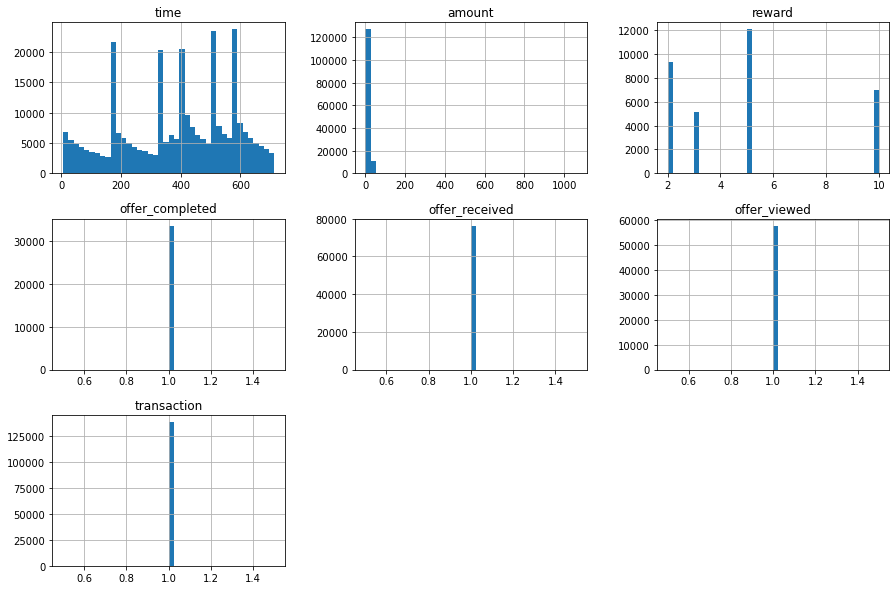

In [ ]:
print("Transactions and offers receive/view/complete plots")
transcript = pd.read_csv("transcript_edited.csv")
transcript[transcript[transcript.columns]!=0].hist(bins=40, figsize=(15, 10))

You can see number of offers that people received, viewed or completed:


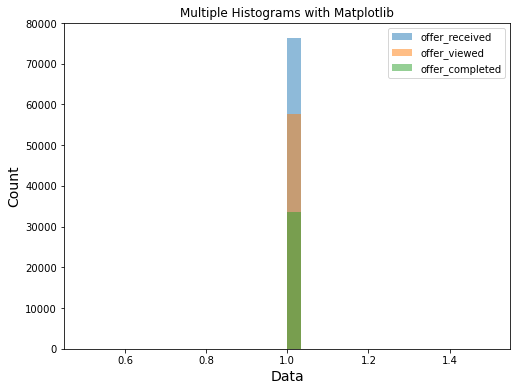

In [ ]:
print("You can see number of offers that people received, viewed or completed:")
plt.figure(figsize=(8,6))
plt.hist(transcript.offer_received[transcript.offer_received!=0], bins=30, alpha=0.5, label="offer_received")
plt.hist(transcript.offer_viewed[transcript.offer_viewed!=0], bins=30, alpha=0.5, label="offer_viewed")
plt.hist(transcript.offer_completed[transcript.offer_completed!=0], bins=30, alpha=0.5, label="offer_completed")
plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.title("Multiple Histograms with Matplotlib")
plt.legend(loc='upper right')

In [ ]:
print("portfolio table review")
portfolio = pd.read_csv("portfolio_edited.csv")
portfolio

portfolio table review


,offer_reward,offer_difficulty,offer_duration,id,web,email,mobile,social,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,0,1,0


Edited profile table's feature histograms:


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'income'}>],
       [<AxesSubplot:title={'center':'membership_duration'}>,
        <AxesSubplot:title={'center':'Male'}>],
       [<AxesSubplot:title={'center':'Female'}>,
        <AxesSubplot:title={'center':'Other'}>]], dtype=object)

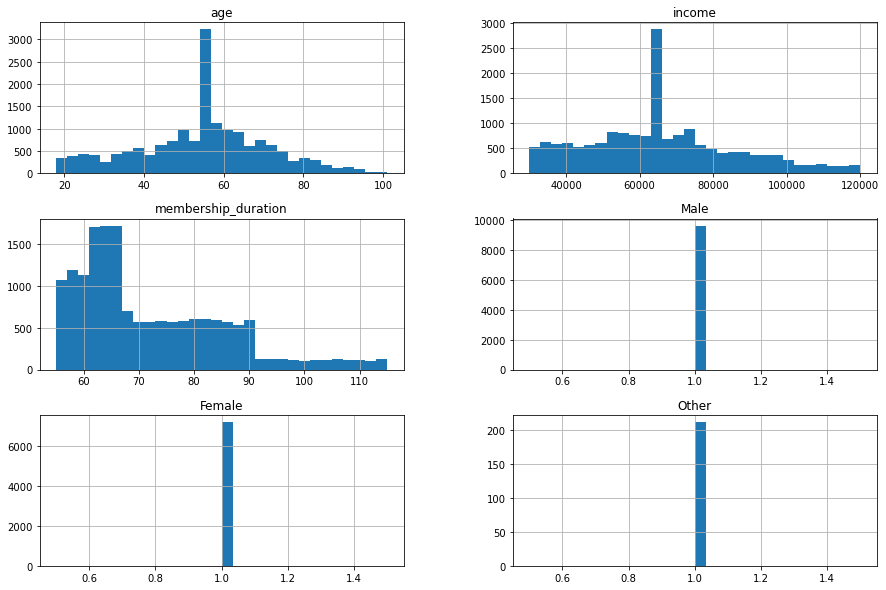

In [ ]:
print("Edited profile table's feature histograms:")
profile = pd.read_csv("profile_edited.csv")
profile[profile[profile.columns]!=0].hist(bins=30, figsize=(15, 10))

Histogram of all features


array([[<AxesSubplot:title={'center':'time'}>,
        <AxesSubplot:title={'center':'cumulative_transaction'}>,
        <AxesSubplot:title={'center':'reward'}>,
        <AxesSubplot:title={'center':'offer_completed'}>,
        <AxesSubplot:title={'center':'offer_received'}>],
       [<AxesSubplot:title={'center':'offer_viewed'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'income'}>,
        <AxesSubplot:title={'center':'membership_duration'}>,
        <AxesSubplot:title={'center':'Male'}>],
       [<AxesSubplot:title={'center':'Female'}>,
        <AxesSubplot:title={'center':'Other'}>,
        <AxesSubplot:title={'center':'offer_reward'}>,
        <AxesSubplot:title={'center':'offer_difficulty'}>,
        <AxesSubplot:title={'center':'offer_duration'}>],
       [<AxesSubplot:title={'center':'web'}>,
        <AxesSubplot:title={'center':'email'}>,
        <AxesSubplot:title={'center':'mobile'}>,
        <AxesSubplot:title={'center':'social'}>,
  

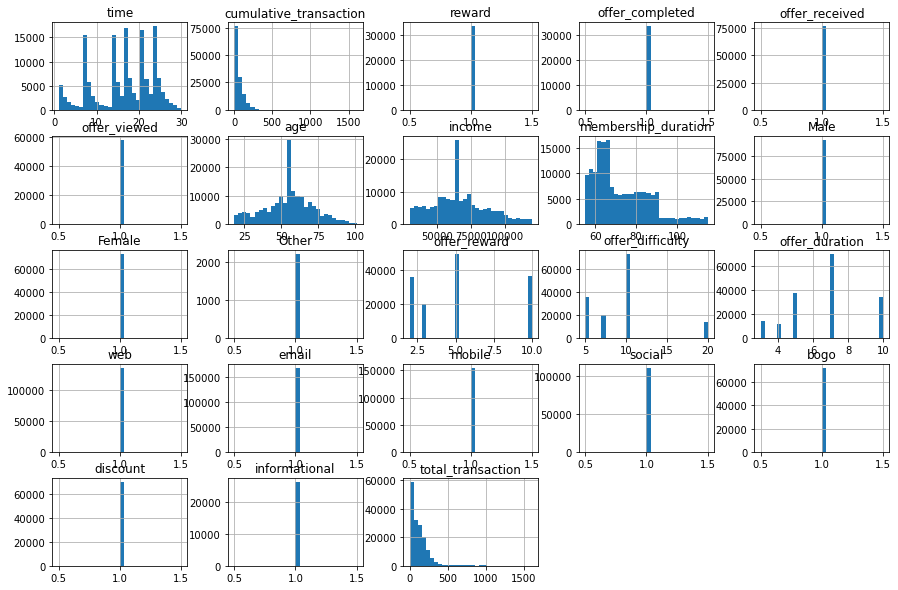

In [ ]:
#plot my source table (my_starbuck) feature histograms
my_starbuck = pd.read_csv("my_starbuck.csv")
print("Histogram of all features")
my_starbuck[my_starbuck[my_starbuck.columns]!=0].hist(bins=30, figsize=(15, 10))

Histogram of female customer's completed rewards 


<AxesSubplot:>

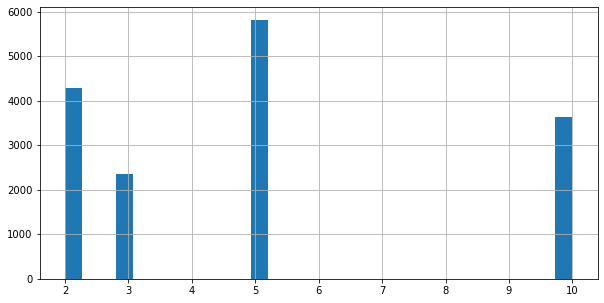

In [ ]:
print("Histogram of female customer's completed rewards ")
(my_starbuck[(my_starbuck['Female']==1) & (my_starbuck['reward']==1)]['offer_reward']).hist(bins=30, figsize=(10, 5))

Histogram of female customer's completed offer types 


array([[<AxesSubplot:title={'center':'bogo'}>,
        <AxesSubplot:title={'center':'discount'}>],
       [<AxesSubplot:title={'center':'informational'}>, <AxesSubplot:>]],
      dtype=object)

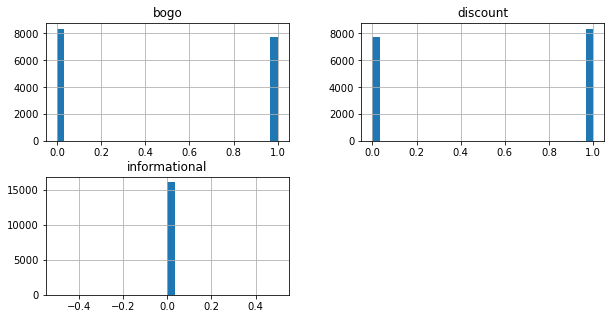

In [ ]:
print("Histogram of female customer's completed offer types ")
(my_starbuck[(my_starbuck['Female']==1) & (my_starbuck['reward']==1) ][['bogo',	'discount',	'informational']]).hist(bins=30, figsize=(10, 5))

Histogram of male customer's completed rewards 


<AxesSubplot:>

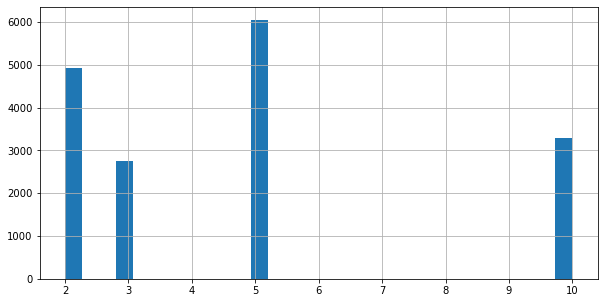

In [ ]:
print("Histogram of male customer's completed rewards ")
(my_starbuck[(my_starbuck['Male']==1) & (my_starbuck['reward']==1)]['offer_reward']).hist(bins=30, figsize=(10, 5))

Histogram of male customer's completed offer types 


array([[<AxesSubplot:title={'center':'bogo'}>,
        <AxesSubplot:title={'center':'discount'}>],
       [<AxesSubplot:title={'center':'informational'}>, <AxesSubplot:>]],
      dtype=object)

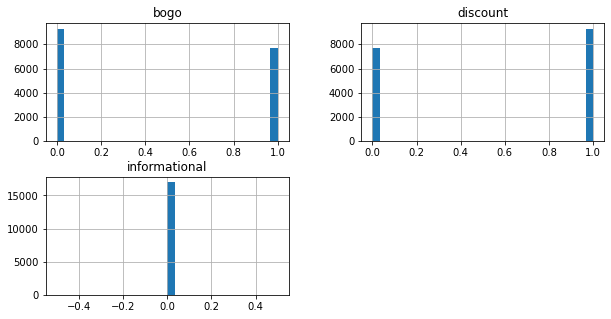

In [ ]:
print("Histogram of male customer's completed offer types ")
(my_starbuck[(my_starbuck['Male']==1) & (my_starbuck['reward']==1) ][['bogo',	'discount',	'informational']]).hist(bins=30, figsize=(10, 5))

# Training with Scikit_Learn random forest model 

In [ ]:
my_starbuck = pd.read_csv("my_starbuck.csv")
len(my_starbuck)

167581

In [ ]:
print("Number of rows containing Other genders:")
my_starbuck[(my_starbuck['Other']==1)]['person'].count()

Number of rows containing Other genders:


2190

In [ ]:
#Reading my source table
my_starbuck = pd.read_csv("my_starbuck.csv")

#Deleting the rows containing Other genders
my_starbuck = my_starbuck.drop(my_starbuck[(my_starbuck['Other']==1)].index)

#Reseting my goal table indexes
my_starbuck.reset_index(drop=True, inplace=True)

#drop unimportant and unnecessary columns
my_starbuck = my_starbuck.drop([ 'person','offers', 'Other',  'email',
                                'informational', 'offer_completed', 'offer_received', 
                                'offer_viewed', 'total_transaction',], axis=1)
#Check my source table "my_starbuck"
my_starbuck.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165391 entries, 0 to 165390
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   time                    165391 non-null  float64
 1   cumulative_transaction  165391 non-null  float64
 2   reward                  165391 non-null  int64  
 3   age                     165391 non-null  int64  
 4   income                  165391 non-null  float64
 5   membership_duration     165391 non-null  int64  
 6   Male                    165391 non-null  int64  
 7   Female                  165391 non-null  int64  
 8   offer_reward            165391 non-null  float64
 9   offer_difficulty        165391 non-null  float64
 10  offer_duration          165391 non-null  float64
 11  web                     165391 non-null  float64
 12  mobile                  165391 non-null  float64
 13  social                  165391 non-null  float64
 14  bogo                

In [ ]:
#Do some preprocessing if necessary
from sklearn import preprocessing

#Normalizing some columns that contain big numbers
x = my_starbuck[['income', 'age', 'time','membership_duration',]].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_columns = pd.DataFrame(x_scaled)

data = my_starbuck.copy()
data['income'] = normalized_columns[0]
data['age'] = normalized_columns[1]
data['time'] = normalized_columns[2]
data['membership_duration'] = normalized_columns[3]
data = data.round(5)

In [ ]:
from sklearn.model_selection import train_test_split

#splitting the data to train and test
train, test = train_test_split(
    data, test_size=0.25, random_state=42)

In [ ]:
#Saving the train and test files to csv
train.to_csv("train.csv")
test.to_csv("test.csv")

# Save data to S3, SageMaker will take training data from s3
trainpath = sess.upload_data(
    path="train.csv", bucket=bucket, key_prefix="capstone"
)

testpath = sess.upload_data(
    path="test.csv", bucket=bucket, key_prefix="capstone"
)
#print(train.shape, test.shape)

## Write model training job on a RandomForestRegressor to script.py file

In [ ]:
%%writefile script.py

import argparse
import joblib
import os

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor


# inference functions ---------------
def model_fn(model_dir):
    clf = joblib.load(os.path.join(model_dir, "model.joblib"))
    return clf


if __name__ == "__main__":

    print("extracting arguments")
    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    # to simplify the demo we don't use all sklearn RandomForest hyperparameters
    parser.add_argument("--n-estimators", type=int, default=10)
    parser.add_argument("--min-samples-leaf", type=int, default=3)

    # Data, model, and output directories
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--test", type=str, default=os.environ.get("SM_CHANNEL_TEST"))
    parser.add_argument("--train-file", type=str, default="train.csv")
    parser.add_argument("--test-file", type=str, default="test.csv")
    parser.add_argument(
        "--features", type=str
    )  # in this script we ask user to explicitly name features
    parser.add_argument(
        "--target", type=str
    )  # in this script we ask user to explicitly name the target

    args, _ = parser.parse_known_args()

    print("reading data")
    train_df = pd.read_csv(os.path.join(args.train, args.train_file))
    test_df = pd.read_csv(os.path.join(args.test, args.test_file))

    print("building training and testing datasets")
    X_train = train_df[args.features.split()]
    X_test = test_df[args.features.split()]
    y_train = train_df[args.target]
    y_test = test_df[args.target]

    # train
    print("training model")
    model = RandomForestRegressor(
        n_estimators=args.n_estimators, min_samples_leaf=args.min_samples_leaf, n_jobs=-1
    )

    model.fit(X_train, y_train)

    # print abs error
    print("validating model")
    abs_err = np.abs(model.predict(X_test) - y_test)

    # print couple perf metrics
    for q in [10, 50, 90]:
        print("AE-at-" + str(q) + "th-percentile: " + str(np.percentile(a=abs_err, q=q)))

    # persist model
    path = os.path.join(args.model_dir, "model.joblib")
    joblib.dump(model, path)
    print("model persisted at " + path)
    print(args.min_samples_leaf)



Overwriting script.py


In [ ]:
print("train features: ", train.columns)
feature_names = ['time', 'reward', 'age', 'income',
       'membership_duration', 'Male', 'Female', 'offer_reward',
       'offer_difficulty', 'offer_duration', 'web', 'mobile', 'social', 'bogo',
       'discount' ]

train features:  Index(['time', 'cumulative_transaction', 'reward', 'age', 'income',
       'membership_duration', 'Male', 'Female', 'offer_reward',
       'offer_difficulty', 'offer_duration', 'web', 'mobile', 'social', 'bogo',
       'discount'],
      dtype='object')


## Local training

In [ ]:
! python script.py --n-estimators 100 \
                   --min-samples-leaf 2 \
                   --model-dir ./ \
                   --train ./ \
                   --test ./ \
                   --features 'time reward age income membership_duration Male Female offer_reward offer_difficulty offer_duration web mobile social bogo discount' \
                   --target cumulative_transaction

extracting arguments
reading data
building training and testing datasets
training model
validating model
AE-at-10th-percentile: 0.16653535714286247
AE-at-50th-percentile: 14.753534285714306
AE-at-90th-percentile: 66.80788100288605
model persisted at ./model.joblib
2


## Launch a Tuning Job

In [ ]:
# We use the Estimator from the SageMaker Python SDK
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"
hyperparameters = {"n-estimators": 147, \
                   "min-samples-leaf":  2, \
                  "features": 'time reward age income membership_duration Male Female offer_reward offer_difficulty offer_duration web mobile social bogo discount' , \
                   "target": 'cumulative_transaction', }

sklearn_estimator = SKLearn(
    entry_point="script.py",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.m4.xlarge",#"ml.c5.xlarge",#"ml.m4.xlarge",
    framework_version=FRAMEWORK_VERSION,
    base_job_name="train-star",
    metric_definitions=[{"Name": "median-AE", "Regex": "AE-at-50th-percentile: ([0-9.]+).*$"}],
    hyperparameters=hyperparameters,
)


In [ ]:
# we use the Hyperparameter Tuner
from sagemaker.tuner import IntegerParameter

# Define exploration boundaries
hyperparameter_ranges = {
    "n-estimators": IntegerParameter(20, 200),
    "min-samples-leaf": IntegerParameter(2, 10),
}

# create Optimizer
Optimizer = sagemaker.tuner.HyperparameterTuner(
    estimator=sklearn_estimator,
    hyperparameter_ranges=hyperparameter_ranges,
    base_tuning_job_name="tuner-star",
    objective_type="Minimize",
    objective_metric_name="median-AE",
    metric_definitions=[
        {"Name": "median-AE", "Regex": "AE-at-50th-percentile: ([0-9.]+).*$"}
    ],  # extract tracked metric from logs with regexp
    max_jobs=10,
    max_parallel_jobs=2,
)

In [ ]:
import time
tic = time.clock()

Optimizer.fit({"train": trainpath, "test": testpath})

toc = time.clock()
print(toc - tic)

..............................................................................................................................!
0.6400000000000006


In [ ]:
# get tuner results in a df
results = Optimizer.analytics().dataframe()
while results.empty:
    time.sleep(1)
    results = Optimizer.analytics().dataframe()
results.head()


,min-samples-leaf,n-estimators,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,2.0,149.0,tuner-star-220212-1631-010-14b18466,Completed,14.619602,2022-02-12 16:57:49+00:00,2022-02-12 17:00:33+00:00,164.0
1,2.0,144.0,tuner-star-220212-1631-009-5f6264cf,Completed,14.598150,2022-02-12 16:56:01+00:00,2022-02-12 16:59:24+00:00,203.0
2,2.0,147.0,tuner-star-220212-1631-008-f423754e,Completed,14.565795,2022-02-12 16:51:41+00:00,2022-02-12 16:54:23+00:00,162.0
3,2.0,190.0,tuner-star-220212-1631-007-b1bdb91a,Completed,14.626628,2022-02-12 16:49:57+00:00,2022-02-12 16:52:59+00:00,182.0
4,2.0,174.0,tuner-star-220212-1631-006-16544424,Completed,14.662675,2022-02-12 16:45:37+00:00,2022-02-12 16:48:24+00:00,167.0


In [ ]:
best_estimator=Optimizer.best_estimator()


2022-02-12 16:54:23 Starting - Preparing the instances for training
2022-02-12 16:54:23 Downloading - Downloading input data
2022-02-12 16:54:23 Training - Training image download completed. Training in progress.
2022-02-12 16:54:23 Uploading - Uploading generated training model
2022-02-12 16:54:23 Completed - Training job completed


In [ ]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"median-AE"',
 'features': '"time reward age income membership_duration Male Female offer_reward offer_difficulty offer_duration web mobile social bogo discount"',
 'min-samples-leaf': '2',
 'n-estimators': '147',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"SKLearn"',
 'sagemaker_estimator_module': '"sagemaker.sklearn.estimator"',
 'sagemaker_job_name': '"train-star-2022-02-12-16-31-17-481"',
 'sagemaker_program': '"script.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-201557610166/train-star-2022-02-12-16-31-17-481/source/sourcedir.tar.gz"',
 'target': '"cumulative_transaction"'}

In [ ]:
hyperparameters = {"n-estimators": int(best_estimator.hyperparameters()['n-estimators'].replace('"', '')), \
                   "min-samples-leaf":  int(best_estimator.hyperparameters()['min-samples-leaf'].replace('"', '')), \
                  "features": best_estimator.hyperparameters()['features'].replace('"', ''), \
                   "target": best_estimator.hyperparameters()['target'].replace('"', ''), }
hyperparameters

{'n-estimators': 147,
 'min-samples-leaf': 2,
 'features': 'time reward age income membership_duration Male Female offer_reward offer_difficulty offer_duration web mobile social bogo discount',
 'target': 'cumulative_transaction'}

## Launching a training job on best hyperparameters

In [ ]:
# We use the Estimator from the SageMaker Python SDK
from sagemaker.sklearn.estimator import SKLearn
import time

FRAMEWORK_VERSION = "0.23-1"

sklearn_estimator = SKLearn(
    entry_point="script.py",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.m4.xlarge",#"ml.c5.xlarge",#"ml.m4.xlarge",
    framework_version=FRAMEWORK_VERSION,
    base_job_name="train-star",
    metric_definitions=[{"Name": "median-AE", "Regex": "AE-at-50th-percentile: ([0-9.]+).*$"}],
    hyperparameters=hyperparameters,
)

tic = time.clock()

# launch training job
sklearn_estimator.fit({"train": trainpath, "test": testpath}, wait=True)

toc = time.clock()
print(toc - tic)

2022-02-13 02:43:41 Starting - Starting the training job...
2022-02-13 02:44:05 Starting - Launching requested ML instancesProfilerReport-1644720221: InProgress
......
2022-02-13 02:45:11 Starting - Preparing the instances for training............
2022-02-13 02:47:06 Downloading - Downloading input data
2022-02-13 02:47:06 Training - Downloading the training image.....2022-02-13 02:47:47,454 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2022-02-13 02:47:47,456 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-02-13 02:47:47,469 sagemaker_sklearn_container.training INFO     Invoking user training script.
2022-02-13 02:47:47,864 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-02-13 02:47:47,878 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-02-13 02:47:47,893 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus i

## Deploy to a real-time endpoint

In [ ]:
from sagemaker.sklearn.model import SKLearnModel

sklearn_estimator.latest_training_job.wait(logs="None")
artifact = sm_boto3.describe_training_job(
    TrainingJobName= sklearn_estimator.latest_training_job.name#'train-star-2022-02-11-09-09-36-428' 
)["ModelArtifacts"]["S3ModelArtifacts"]

print("Model artifact persisted at " + artifact)

model = SKLearnModel(
    model_data=artifact,
    role=get_execution_role(),
    entry_point="script.py",
    framework_version=FRAMEWORK_VERSION,
)

predictor = model.deploy(instance_type="ml.c5.large", initial_instance_count=1)


2022-02-13 02:49:26 Starting - Preparing the instances for training
2022-02-13 02:49:26 Downloading - Downloading input data
2022-02-13 02:49:26 Training - Training image download completed. Training in progress.
2022-02-13 02:49:26 Uploading - Uploading generated training model
2022-02-13 02:49:26 Completed - Training job completed
Model artifact persisted at s3://sagemaker-us-east-1-201557610166/train-star-2022-02-13-02-43-41-075/output/model.tar.gz
-----!

## Invoke the endpoint

In [ ]:
# the SKLearnPredictor does the serialization from pandas for us
response = predictor.predict(test[feature_names])
test_target = test['cumulative_transaction']
test_target = test_target.to_numpy() 

print("response \t\t target")
for i in range(100):
    print(response[i] , "\t",test_target[i])

response 		 target
42.741547781017154 	 42.75
62.41656648850017 	 31.57
5.431426303854877 	 0.0
111.42925178166503 	 61.63
119.83790046971173 	 146.2
30.473342484612882 	 37.57
81.09920667314543 	 29.75
73.52277721088433 	 73.36
5.504794001727676 	 2.54
35.42429664723034 	 20.41
132.62019595616022 	 138.12
45.86012331281719 	 23.98
57.533254994061096 	 33.6
61.2219977324263 	 37.06
56.77866553287983 	 20.52
14.928407446672761 	 128.26
20.11640678652412 	 29.56
39.824623744735995 	 121.08
64.26413265306118 	 33.97
6.332217624867687 	 8.84
20.02664085951841 	 12.79
15.32111321671525 	 0.0
138.58601587301595 	 789.81
110.23857701652086 	 55.65
144.37812649821834 	 155.09
107.90099708454815 	 124.15
69.68707636864272 	 83.38
124.63938921282798 	 130.97
0.0 	 0.0
8.765819327214734 	 3.92
1.18198223733938 	 0.05
81.47381827016518 	 99.23
89.95767454918476 	 108.05
48.186443013713415 	 109.19
0.0 	 0.0
89.26236799481691 	 76.01
10.935080793356306 	 0.0
50.988030936184 	 19.95
95.8436182917611

## Evaluate the sklearn random forest model

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mean_squared_error = mean_squared_error(test_target, response)
mean_absolute_error = mean_absolute_error(test_target, response)
r2_score = r2_score(test_target, response)
print(f"R2 score: {r2_score}, mean_squared_error: {mean_squared_error}, mean_absolute_error {mean_absolute_error}")

R2 score: 0.4523693254058069, mean_squared_error: 4236.3759983377595, mean_absolute_error 29.62099167956011


## Delete the endpoint

In [ ]:
#Don’t forget to delete the endpoint!
predictor.delete_endpoint()

# Training with autogluon.tabular

Because the R2 score of the Scikit_Learn Random Forest model is rather low, we train the dataset using Autogluon Tabular models to check if we obtain better results. We know that autogluon.tabular contains RFModel (Random Forest model (scikit-learn)) as one of its models. So we hope we will certainly improve the result.

In [ ]:
from sklearn.model_selection import train_test_split

#Read from my source table
my_starbuck = pd.read_csv("my_starbuck.csv")

#Splitting to train and test files
train, test = train_test_split(
    my_starbuck, test_size=0.25, random_state=42
)
print(train.shape, test.shape)

(125685, 25) (41896, 25)


In [ ]:
from autogluon.tabular import TabularPredictor

#Training with Autogluon Tabular
save_path = 'transaction_models'
predictor = TabularPredictor('cumulative_transaction', problem_type='regression', 
                                          path=save_path, learner_kwargs={'ignored_columns':['person', 'offers','Other', 'email', 'informational', 'offer_completed', 'offer_received', 'offer_viewed', 'total_transaction']} ).fit(train, time_limit=1200, presets='best_quality')

Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 1200s
AutoGluon will save models to "transaction_models/"
AutoGluon Version:  0.3.1
Train Data Rows:    125685
Train Data Columns: 24
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['person', 'offers', 'Other', 'email', 'informational', 'offer_completed', 'offer_received', 'offer_viewed', 'total_transaction']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2719.5 MB
	Train Data (Original)  Memory Usage: 15.08 MB (0.6% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 8 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting Identi

[1000]	train_set's rmse: 67.4462	valid_set's rmse: 72.2756
[2000]	train_set's rmse: 64.3991	valid_set's rmse: 70.949
[3000]	train_set's rmse: 62.1513	valid_set's rmse: 70.1166
[4000]	train_set's rmse: 60.3196	valid_set's rmse: 69.4032
[5000]	train_set's rmse: 58.7638	valid_set's rmse: 68.7565
[6000]	train_set's rmse: 57.4493	valid_set's rmse: 68.2224
[7000]	train_set's rmse: 56.2667	valid_set's rmse: 67.7579
[8000]	train_set's rmse: 55.1584	valid_set's rmse: 67.3262
[9000]	train_set's rmse: 54.1268	valid_set's rmse: 66.9764
[10000]	train_set's rmse: 53.1959	valid_set's rmse: 66.6644


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 67.5513	valid_set's rmse: 71.3406
[2000]	train_set's rmse: 64.4834	valid_set's rmse: 69.947
[3000]	train_set's rmse: 62.2132	valid_set's rmse: 68.8009
[4000]	train_set's rmse: 60.3734	valid_set's rmse: 67.9136
[5000]	train_set's rmse: 58.8473	valid_set's rmse: 67.1871
[6000]	train_set's rmse: 57.5549	valid_set's rmse: 66.6814
[7000]	train_set's rmse: 56.3238	valid_set's rmse: 66.1776
[8000]	train_set's rmse: 55.1884	valid_set's rmse: 65.7285
[9000]	train_set's rmse: 54.1896	valid_set's rmse: 65.3401
[10000]	train_set's rmse: 53.2666	valid_set's rmse: 64.9022


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 67.5222	valid_set's rmse: 71.1072
[2000]	train_set's rmse: 64.3668	valid_set's rmse: 70.0544
[3000]	train_set's rmse: 62.1027	valid_set's rmse: 69.3741
[4000]	train_set's rmse: 60.2241	valid_set's rmse: 68.8406
[5000]	train_set's rmse: 58.7288	valid_set's rmse: 68.4298
[6000]	train_set's rmse: 57.3932	valid_set's rmse: 68.0304
[7000]	train_set's rmse: 56.2	valid_set's rmse: 67.7252
[8000]	train_set's rmse: 55.0897	valid_set's rmse: 67.3391
[9000]	train_set's rmse: 54.0509	valid_set's rmse: 67.0505
[10000]	train_set's rmse: 53.1481	valid_set's rmse: 66.8169


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 67.775	valid_set's rmse: 69.0587
[2000]	train_set's rmse: 64.7228	valid_set's rmse: 67.8378
[3000]	train_set's rmse: 62.5209	valid_set's rmse: 66.9993
[4000]	train_set's rmse: 60.628	valid_set's rmse: 66.2066
[5000]	train_set's rmse: 59.1019	valid_set's rmse: 65.6267
[6000]	train_set's rmse: 57.7637	valid_set's rmse: 65.1919
[7000]	train_set's rmse: 56.5707	valid_set's rmse: 64.7652
[8000]	train_set's rmse: 55.4603	valid_set's rmse: 64.3597
[9000]	train_set's rmse: 54.4603	valid_set's rmse: 64.0259
[10000]	train_set's rmse: 53.5122	valid_set's rmse: 63.7018


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 67.47	valid_set's rmse: 71.1109
[2000]	train_set's rmse: 64.3558	valid_set's rmse: 70.1605
[3000]	train_set's rmse: 62.0686	valid_set's rmse: 69.418
[4000]	train_set's rmse: 60.2735	valid_set's rmse: 68.8443
[5000]	train_set's rmse: 58.7497	valid_set's rmse: 68.399
[6000]	train_set's rmse: 57.3883	valid_set's rmse: 67.9542
[7000]	train_set's rmse: 56.1951	valid_set's rmse: 67.544
[8000]	train_set's rmse: 55.057	valid_set's rmse: 67.1613
[9000]	train_set's rmse: 54.0333	valid_set's rmse: 66.8042
[10000]	train_set's rmse: 53.1179	valid_set's rmse: 66.4566


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 67.3919	valid_set's rmse: 71.7926
[2000]	train_set's rmse: 64.3149	valid_set's rmse: 70.6614
[3000]	train_set's rmse: 62.0768	valid_set's rmse: 69.7517
[4000]	train_set's rmse: 60.2967	valid_set's rmse: 69.069
[5000]	train_set's rmse: 58.7566	valid_set's rmse: 68.5469
[6000]	train_set's rmse: 57.3911	valid_set's rmse: 68.0959
[7000]	train_set's rmse: 56.2235	valid_set's rmse: 67.6408
[8000]	train_set's rmse: 55.1412	valid_set's rmse: 67.159
[9000]	train_set's rmse: 54.1095	valid_set's rmse: 66.8004
[10000]	train_set's rmse: 53.2038	valid_set's rmse: 66.4999


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 67.8329	valid_set's rmse: 68.4786
[2000]	train_set's rmse: 64.6931	valid_set's rmse: 67.4467
[3000]	train_set's rmse: 62.3997	valid_set's rmse: 66.6354
[4000]	train_set's rmse: 60.5937	valid_set's rmse: 66.0715
[5000]	train_set's rmse: 58.9694	valid_set's rmse: 65.6086
[6000]	train_set's rmse: 57.5987	valid_set's rmse: 65.1932
[7000]	train_set's rmse: 56.3471	valid_set's rmse: 64.8527
[8000]	train_set's rmse: 55.2414	valid_set's rmse: 64.532
[9000]	train_set's rmse: 54.2181	valid_set's rmse: 64.2649
[10000]	train_set's rmse: 53.3048	valid_set's rmse: 64.0508


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 67.3305	valid_set's rmse: 71.9194
[2000]	train_set's rmse: 64.479	valid_set's rmse: 70.6572
[3000]	train_set's rmse: 62.2049	valid_set's rmse: 69.7726
[4000]	train_set's rmse: 60.3526	valid_set's rmse: 69.0452
[5000]	train_set's rmse: 58.7487	valid_set's rmse: 68.5438
[6000]	train_set's rmse: 57.4123	valid_set's rmse: 68.0512
[7000]	train_set's rmse: 56.2087	valid_set's rmse: 67.6232
[8000]	train_set's rmse: 55.0891	valid_set's rmse: 67.1798
[9000]	train_set's rmse: 54.0824	valid_set's rmse: 66.8191
[10000]	train_set's rmse: 53.1473	valid_set's rmse: 66.5331


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 67.7265	valid_set's rmse: 69.0513
[2000]	train_set's rmse: 64.6518	valid_set's rmse: 67.7157
[3000]	train_set's rmse: 62.4002	valid_set's rmse: 66.8655
[4000]	train_set's rmse: 60.5997	valid_set's rmse: 66.2027
[5000]	train_set's rmse: 59.0296	valid_set's rmse: 65.6172
[6000]	train_set's rmse: 57.6546	valid_set's rmse: 65.1255
[7000]	train_set's rmse: 56.474	valid_set's rmse: 64.7067
[8000]	train_set's rmse: 55.3954	valid_set's rmse: 64.3549
[9000]	train_set's rmse: 54.3723	valid_set's rmse: 63.9857
[10000]	train_set's rmse: 53.4561	valid_set's rmse: 63.7094


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 67.5419	valid_set's rmse: 71.2033
[2000]	train_set's rmse: 64.5001	valid_set's rmse: 69.8573
[3000]	train_set's rmse: 62.219	valid_set's rmse: 69.0083
[4000]	train_set's rmse: 60.4244	valid_set's rmse: 68.4355
[5000]	train_set's rmse: 58.9068	valid_set's rmse: 67.9277
[6000]	train_set's rmse: 57.5777	valid_set's rmse: 67.4765
[7000]	train_set's rmse: 56.3814	valid_set's rmse: 67.0869
[8000]	train_set's rmse: 55.2787	valid_set's rmse: 66.7515
[9000]	train_set's rmse: 54.2499	valid_set's rmse: 66.4298
[10000]	train_set's rmse: 53.3152	valid_set's rmse: 66.1257


	-65.5572	 = Validation score   (root_mean_squared_error)
	582.06s	 = Training   runtime
	64.22s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 125.78s of the 525.84s of remaining time.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 54.5002	valid_set's rmse: 62.1148
[2000]	train_set's rmse: 47.6962	valid_set's rmse: 56.9715


	Ran out of time, early stopping on iteration 2072. Best iteration is:
	[2072]	train_set's rmse: 47.3573	valid_set's rmse: 56.7526
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 54.5674	valid_set's rmse: 60.3205
[2000]	train_set's rmse: 47.5296	valid_set's rmse: 55.6455


	Ran out of time, early stopping on iteration 2049. Best iteration is:
	[2049]	train_set's rmse: 47.3345	valid_set's rmse: 55.5323
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 54.2875	valid_set's rmse: 62.4273
[2000]	train_set's rmse: 47.421	valid_set's rmse: 58.414


	Ran out of time, early stopping on iteration 2059. Best iteration is:
	[2059]	train_set's rmse: 47.0605	valid_set's rmse: 58.2617
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 54.8738	valid_set's rmse: 59.186
[2000]	train_set's rmse: 48.3066	valid_set's rmse: 54.4161


	Ran out of time, early stopping on iteration 2136. Best iteration is:
	[2135]	train_set's rmse: 47.5743	valid_set's rmse: 54.012
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 54.2972	valid_set's rmse: 61.5108
[2000]	train_set's rmse: 47.6551	valid_set's rmse: 57.3943


	Ran out of time, early stopping on iteration 2129. Best iteration is:
	[2129]	train_set's rmse: 46.9481	valid_set's rmse: 56.9764
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 54.4928	valid_set's rmse: 61.4319
[2000]	train_set's rmse: 47.6418	valid_set's rmse: 56.881


	Ran out of time, early stopping on iteration 2127. Best iteration is:
	[2127]	train_set's rmse: 46.9658	valid_set's rmse: 56.4961
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 54.4055	valid_set's rmse: 59.063
[2000]	train_set's rmse: 47.4683	valid_set's rmse: 54.9111


	Ran out of time, early stopping on iteration 2180. Best iteration is:
	[2179]	train_set's rmse: 46.5501	valid_set's rmse: 54.2755
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 54.3868	valid_set's rmse: 61.7305
[2000]	train_set's rmse: 47.4121	valid_set's rmse: 57.5526


	Ran out of time, early stopping on iteration 2213. Best iteration is:
	[2213]	train_set's rmse: 46.3159	valid_set's rmse: 56.8764
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 54.6573	valid_set's rmse: 58.6823


	Ran out of time, early stopping on iteration 1899. Best iteration is:
	[1898]	train_set's rmse: 48.5682	valid_set's rmse: 55.021
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 54.7852	valid_set's rmse: 60.7595
[2000]	train_set's rmse: 47.7698	valid_set's rmse: 56.0507


	Ran out of time, early stopping on iteration 2497. Best iteration is:
	[2495]	train_set's rmse: 45.6198	valid_set's rmse: 54.9213
	-55.9276	 = Validation score   (root_mean_squared_error)
	111.13s	 = Training   runtime
	10.75s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 399.85s of remaining time.
	-50.0323	 = Validation score   (root_mean_squared_error)
	1.34s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 9 L2 models ...
Fitting model: LightGBMXT_BAG_L2 ... Training model for up to 398.49s of the 398.47s of remaining time.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of Li

[1000]	train_set's rmse: 39.7944	valid_set's rmse: 48.5087
[2000]	train_set's rmse: 36.0001	valid_set's rmse: 47.8952
[3000]	train_set's rmse: 33.5714	valid_set's rmse: 47.6067
[4000]	train_set's rmse: 31.7202	valid_set's rmse: 47.4679
[5000]	train_set's rmse: 30.3401	valid_set's rmse: 47.3564


	Ran out of time, early stopping on iteration 5141. Best iteration is:
	[5011]	train_set's rmse: 30.3217	valid_set's rmse: 47.3524
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 39.3644	valid_set's rmse: 47.2599
[2000]	train_set's rmse: 35.8582	valid_set's rmse: 46.6734
[3000]	train_set's rmse: 33.5673	valid_set's rmse: 46.3893
[4000]	train_set's rmse: 31.7727	valid_set's rmse: 46.1794
[5000]	train_set's rmse: 30.3496	valid_set's rmse: 46.0776


	Ran out of time, early stopping on iteration 5309. Best iteration is:
	[5121]	train_set's rmse: 30.1985	valid_set's rmse: 46.0444
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 39.4628	valid_set's rmse: 46.8373
[2000]	train_set's rmse: 35.8213	valid_set's rmse: 46.1463
[3000]	train_set's rmse: 33.5003	valid_set's rmse: 45.9459
[4000]	train_set's rmse: 31.7411	valid_set's rmse: 45.8721


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 39.7133	valid_set's rmse: 48.1603
[2000]	train_set's rmse: 36.1107	valid_set's rmse: 47.4611
[3000]	train_set's rmse: 33.739	valid_set's rmse: 47.2108
[4000]	train_set's rmse: 31.8832	valid_set's rmse: 47.0068


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 40.1051	valid_set's rmse: 44.6321
[2000]	train_set's rmse: 36.2245	valid_set's rmse: 43.7109
[3000]	train_set's rmse: 33.8473	valid_set's rmse: 43.39
[4000]	train_set's rmse: 32.019	valid_set's rmse: 43.2602
[5000]	train_set's rmse: 30.5904	valid_set's rmse: 43.1677


	Ran out of time, early stopping on iteration 5629. Best iteration is:
	[5540]	train_set's rmse: 29.8704	valid_set's rmse: 43.1224
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 39.6714	valid_set's rmse: 48.1419
[2000]	train_set's rmse: 35.7397	valid_set's rmse: 47.7656
[3000]	train_set's rmse: 33.337	valid_set's rmse: 47.6684
[4000]	train_set's rmse: 31.5691	valid_set's rmse: 47.6591


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 39.3345	valid_set's rmse: 48.6547
[2000]	train_set's rmse: 35.8531	valid_set's rmse: 48.337
[3000]	train_set's rmse: 33.5665	valid_set's rmse: 48.1166


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 39.5625	valid_set's rmse: 48.5281


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 39.8857	valid_set's rmse: 42.9799
[2000]	train_set's rmse: 36.3288	valid_set's rmse: 42.1012
[3000]	train_set's rmse: 33.8659	valid_set's rmse: 41.8069
[4000]	train_set's rmse: 32.1146	valid_set's rmse: 41.5972
[5000]	train_set's rmse: 30.6114	valid_set's rmse: 41.4692
[6000]	train_set's rmse: 29.3571	valid_set's rmse: 41.4161
[7000]	train_set's rmse: 28.3008	valid_set's rmse: 41.3627
[8000]	train_set's rmse: 27.3637	valid_set's rmse: 41.379
[9000]	train_set's rmse: 26.5225	valid_set's rmse: 41.3721
[10000]	train_set's rmse: 25.7263	valid_set's rmse: 41.3715


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 39.7316	valid_set's rmse: 44.0423


	-45.9132	 = Validation score   (root_mean_squared_error)
	293.71s	 = Training   runtime
	22.17s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 74.24s of the 74.22s of remaining time.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	Ran out of time, early stopping on itera

[1000]	train_set's rmse: 30.4085	valid_set's rmse: 44.271


	Ran out of time, early stopping on iteration 1071. Best iteration is:
	[1011]	train_set's rmse: 30.3363	valid_set's rmse: 44.2561
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 30.6134	valid_set's rmse: 39.4357


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 30.2352	valid_set's rmse: 43.0486


	Ran out of time, early stopping on iteration 1167. Best iteration is:
	[1107]	train_set's rmse: 29.7361	valid_set's rmse: 42.925
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 30.676	valid_set's rmse: 37.7205


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	-42.4255	 = Validation score   (root_mean_squared_error)
	55.81s	 = Training   runtime
	2.91s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 14.09s of the 14.07s of remaining time.
	Time limit exceeded... Skipping RandomForestMSE_BAG_L2.
Fitting model: CatBoost_BAG_L2 ... Training model for up to 10.72s of the 10.71s of remaining time.
	-52.6254	 = Validation score   (root_mean_squared_error)
	7.9s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L2 ... Training model for up to 2.69s of the 2.67s of remaining time.
	Time limit exceeded... Skippin

## My Tabular predictor leaderboard

In [ ]:
#The predictor leaderboard that is produced using the data previously reserved for validation inside fit, and can display extra information about each model:
predictor.leaderboard(extra_info=True, silent=True)

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order,num_features,...,child_model_type,hyperparameters,hyperparameters_fit,ag_args_fit,features,child_hyperparameters,child_hyperparameters_fit,child_ag_args_fit,ancestors,descendants
0,WeightedEnsemble_L3,-42.368650,104.664558,1053.279999,0.002498,0.907678,3,True,9,3,...,GreedyWeightedEnsembleModel,"{'use_orig_features': False, 'max_base_models': 25, 'max_base_models_per_type': 5, 'save_bag_folds': True}",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'ignored_type_group_special': None, 'ignored_type_group_raw': None, 'get_features_kwargs': None, 'get_features_kwargs_extra': None, 'drop_unique': False}","[LightGBMXT_BAG_L2, CatBoost_BAG_L2, LightGBM_BAG_L2]",{'ensemble_size': 100},{'ensemble_size': 93},"{'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'ignored_type_group_special': None, 'ignored_type_group_raw': None, 'get_features_kwargs': None, 'get_features_kwargs_extra': None, 'drop_unique': False}","[KNeighborsUnif_BAG_L1, LightGBM_BAG_L1, KNeighborsDist_BAG_L1, LightGBMXT_BAG_L2, LightGBM_BAG_L2, CatBoost_BAG_L2, LightGBMXT_BAG_L1]",[]
1,LightGBM_BAG_L2,-42.425539,82.439590,750.768911,2.914795,55.807490,2,True,7,19,...,LGBModel,"{'use_orig_features': True, 'max_base_models': 25, 'max_base_models_per_type': 5, 'save_bag_folds': True}",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'ignored_type_group_special': None, 'ignored_type_group_raw': None, 'get_features_kwargs': None, 'get_features_kwargs_extra': None, 'drop_unique': False}","[KNeighborsUnif_BAG_L1, LightGBM_BAG_L1, bogo, mobile, KNeighborsDist_BAG_L1, age, offer_reward, discount, social, Female, offer_duration, LightGBMXT_BAG_L1, Male, time, web, reward, income, membership_duration, offer_difficulty]","{'num_boost_round': 10000, 'num_threads': -1, 'learning_rate': 0.05, 'objective': 'regression', 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True}",{'num_boost_round': 691},"{'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'ignored_type_group_special': None, 'ignored_type_group_raw': ['object'], 'get_features_kwargs': None, 'get_features_kwargs_extra': None}","[KNeighborsUnif_BAG_L1, LightGBMXT_BAG_L1, KNeighborsDist_BAG_L1, LightGBM_BAG_L1]",[WeightedEnsemble_L3]
2,LightGBMXT_BAG_L2,-45.913178,101.696354,988.669068,22.171559,293.707647,2,True,6,19,...,LGBModel,"{'use_orig_features': True, 'max_base_models': 25, 'max_base_models_per_type': 5, 'save_bag_folds': True}",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'ignored_type_group_special': None, 'ignored_type_group_raw': None, 'get_features_kwargs': None, 'get_features_kwargs_extra': None, 'drop_unique': False}","[KNeighborsUnif_BAG_L1, LightGBM_BAG_L1, bogo, mobile, KNeighborsDist_BAG_L1, age, offer_reward, discount, social, Female, offer_duration, LightGBMXT_BAG_L1, Male, time, web, reward, income, membership_duration, offer_difficulty]","{'num_boost_round': 10000, 'num_threads': -1, 'learning_rate': 0.05, 'objective': 'regression', 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True, 'extra_trees': True}",{'num_boost_round': 4061},"{'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'ignored_type_group_special': None, 'ignored_type_group_raw': ['object'], 'get_features_kwargs': None, 'get_features_kwargs_extra': None}","[KNeighborsUnif_BAG_L1, LightGBMXT_BAG_L1, KNeighborsDist_BAG_L1, LightGBM_BAG_L1]",[WeightedEnsemble_L3]
3,WeightedEnsemble_L2,-50.032328,12.983774,113.341726,0.002828,1.338707,2,True,5,2,...,GreedyWeightedEnsembleModel,"{'use_orig_features': False, 'max_base_models': 25, 'max_base_models_per_type': 5, 'save_bag_folds': T

In [ ]:
print("Predictor features: ", predictor.features())

Predictor features:  ['time', 'reward', 'age', 'income', 'membership_duration', 'Male', 'Female', 'offer_reward', 'offer_difficulty', 'offer_duration', 'web', 'mobile', 'social', 'bogo', 'discount']


## Getting predictions from TabularPredictor

In [ ]:
response = predictor.predict(test)
test_target = test['cumulative_transaction']

In [ ]:
print("response:\n ",response)
print("target:\n",test_target)

response:
  53680    766.571960
60296     44.871216
93002     23.226473
51223     16.035902
63364      0.295056
            ...    
38068     32.941368
96695     11.738913
51438     95.026451
85069    133.813339
88609     19.691917
Name: cumulative_transaction, Length: 41896, dtype: float32
target:
 53680    674.56
60296      8.59
93002      8.48
51223     13.22
63364      0.00
          ...  
38068     34.04
96695      4.60
51438     44.72
85069     71.67
88609      9.95
Name: cumulative_transaction, Length: 41896, dtype: float64


## Evaluate the Autogluon predictor

In [ ]:
predictor.evaluate(test)

Evaluation: root_mean_squared_error on test data: -40.85419444299454
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -40.85419444299454,
    "mean_squared_error": -1669.0652035860114,
    "mean_absolute_error": -18.183393678980757,
    "r2": 0.7690994021106778,
    "pearsonr": 0.8772191133365619,
    "median_absolute_error": -8.33363681793214
}


{'root_mean_squared_error': -40.85419444299454,
 'mean_squared_error': -1669.0652035860114,
 'mean_absolute_error': -18.183393678980757,
 'r2': 0.7690994021106778,
 'pearsonr': 0.8772191133365619,
 'median_absolute_error': -8.33363681793214}

## Feature importance

In [ ]:
feature_importance = predictor.feature_importance(test)
feature_importance

Computing feature importance via permutation shuffling for 15 features using 1000 rows with 3 shuffle sets...
	731.77s	= Expected runtime (243.92s per shuffle set)
	443.75s	= Actual runtime (Completed 3 of 3 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
income,47.165292,7.170958,0.003809,3,88.255674,6.074910
age,37.275802,9.836164,0.011216,3,93.638111,-19.086508
time,34.273346,6.786459,0.006409,3,73.160507,-4.613814
membership_duration,33.096836,4.776246,0.003435,3,60.465258,5.728414
offer_difficulty,6.951953,1.607391,0.008679,3,16.162484,-2.258577
offer_reward,3.767608,0.957463,0.010428,3,9.253979,-1.718764
offer_duration,3.376406,0.957187,0.012879,3,8.861195,-2.108382
Male,3.344184,2.300363,0.064053,3,16.525521,-9.837153
reward,1.312406,0.448571,0.018402,3,3.882767,-1.257955
Female,1.013403,1.332393,0.159194,3,8.648163,-6.621358


In [ ]:
predictor.get_model_best()

'WeightedEnsemble_L3'

# Results:

We can observe that the WeightedEnsemble model (that implements Ensemble Selection) is trained in the stack level 3 can predict our data at the best. A model with “_L3” suffix is a not base model, meaning it depends on other models.
